# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [8]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [7]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):q
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [8]:
!labelme

2024-05-15 11:15:29,267 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Mia Nguyen\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [14]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

In [16]:
images.as_numpy_iterator().next()

array([[[  9,  10,   0],
        [ 20,  21,   3],
        [ 41,  42,  28],
        ...,
        [142, 154, 132],
        [141, 153, 129],
        [140, 152, 128]],

       [[  3,   4,   0],
        [ 15,  16,   0],
        [ 39,  40,  26],
        ...,
        [138, 153, 130],
        [137, 153, 127],
        [136, 152, 126]],

       [[ 30,  31,  17],
        [ 35,  35,  23],
        [ 48,  46,  34],
        ...,
        [130, 153, 127],
        [130, 153, 125],
        [130, 153, 125]],

       ...,

       [[ 42,  45,  36],
        [ 44,  47,  38],
        [ 44,  47,  38],
        ...,
        [148, 156, 145],
        [138, 144, 134],
        [131, 137, 127]],

       [[ 46,  45,  40],
        [ 46,  45,  40],
        [ 44,  43,  38],
        ...,
        [160, 163, 156],
        [160, 161, 155],
        [159, 160, 154]],

       [[ 53,  50,  45],
        [ 52,  49,  44],
        [ 48,  45,  40],
        ...,
        [146, 147, 141],
        [145, 144, 139],
        [145, 144, 139]]

In [17]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

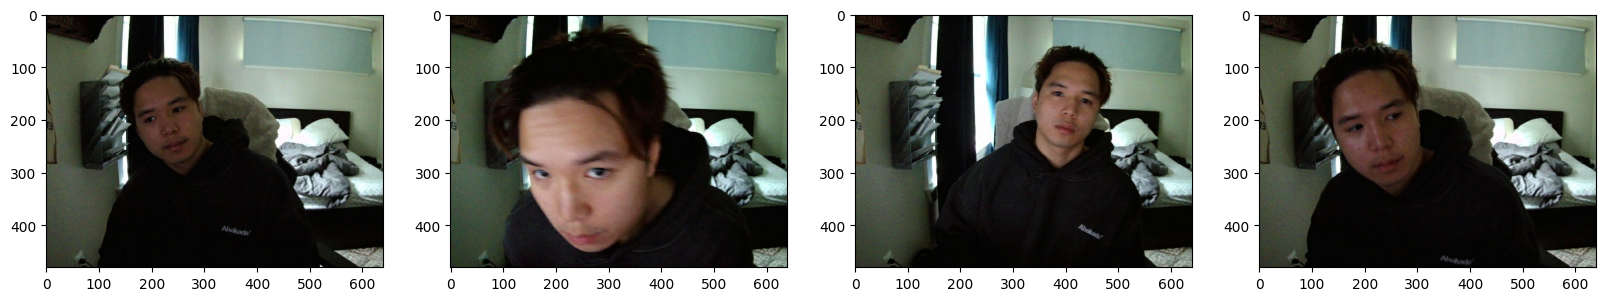

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [21]:
90*.7 # 63 to train

62.99999999999999

In [22]:
90*.15 # 14 and 16 to test and val

13.5

### 3.2 Move the Matching Labels

In [23]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [24]:
import albumentations as alb

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [37]:
img = cv2.imread(os.path.join('data','train', 'images','14a1bd32-12cc-11ef-8247-00d86152aea5.jpg'))

In [36]:
with open(os.path.join('data', 'train', 'labels', '14a1bd32-12cc-11ef-8247-00d86152aea5.json'), 'r') as f:
    label = json.load(f)

In [39]:
label['shapes'][0]['points']

[[298.9473684210526, 58.94736842105266],
 [476.3157894736841, 288.94736842105266]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [40]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [41]:
coords

[298.9473684210526, 58.94736842105266, 476.3157894736841, 288.94736842105266]

In [42]:
coords = list(np.divide(coords, [640,480,640,480]))

In [43]:
coords

[0.4671052631578947,
 0.12280701754385971,
 0.7442434210526314,
 0.6019736842105263]

### 4.4 Apply Augmentations and View Results

In [44]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [45]:
augmented['bboxes'][0][2:]

(0.7273684210526313, 0.9112280701754385)

In [46]:
augmented['bboxes']

[(0.3332163742690058,
  0.4001169590643274,
  0.7273684210526313,
  0.9112280701754385)]

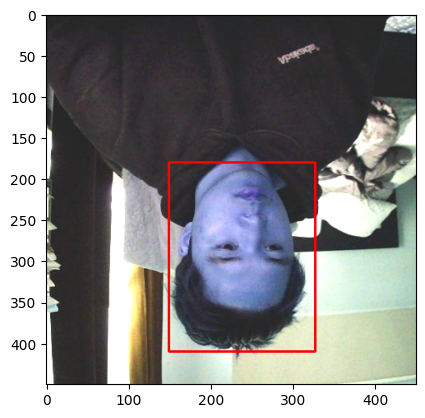

In [47]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [48]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type


### 5.2 Load Augmented Images to Tensorflow Dataset

In [49]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [50]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [51]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [52]:
train_images.as_numpy_iterator().next()

array([[[0.2647059 , 0.2622549 , 0.25735295],
        [0.2634804 , 0.2613358 , 0.2564338 ],
        [0.26556373, 0.27340686, 0.26458332],
        ...,
        [0.05226716, 0.0091299 , 0.03265931],
        [0.05833333, 0.01519608, 0.04656863],
        [0.04852941, 0.00784314, 0.03921569]],

       [[0.2610907 , 0.27303922, 0.2821691 ],
        [0.2541054 , 0.25845587, 0.26813725],
        [0.26139706, 0.26531863, 0.2810049 ],
        ...,
        [0.05055147, 0.01525735, 0.0348652 ],
        [0.05441177, 0.01525735, 0.04644608],
        [0.05343137, 0.01421569, 0.04803922]],

       [[0.23872548, 0.25618872, 0.28615198],
        [0.26292893, 0.2771446 , 0.28241423],
        [0.25496325, 0.2627451 , 0.25300246],
        ...,
        [0.04313726, 0.00784314, 0.02745098],
        [0.05098039, 0.0122549 , 0.04215686],
        [0.05110294, 0.01188726, 0.0432598 ]],

       ...,

       [[0.15006128, 0.08731618, 0.09908088],
        [0.17371324, 0.11636029, 0.12763481],
        [0.11409314, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [53]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [54]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [56]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [57]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.542 , 0.4263, 0.8867, 0.852 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [58]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 960, 960)

### 7.2 Create Final Datasets (Images/Labels)

In [375]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [376]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [377]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [378]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.1453 , 0.375  , 0.569  ],
        [0.6895 , 0.1208 , 1.     , 0.557  ],
        [0.1399 , 0.1299 , 0.4944 , 0.4902 ],
        [0.04282, 0.4668 , 0.3352 , 0.799  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.5015 , 0.2664 , 0.863  , 0.6255 ],
        [0.2593 , 0.4644 , 0.5854 , 0.8237 ],
        [0.5024 , 0.2031 , 0.795  , 0.535  ]], dtype=float16))

### 7.3 View Images and Annotations

In [379]:
data_samples = train.as_numpy_iterator()

In [380]:
res = data_samples.next()

[0.3877 0.3118 0.926  0.9434]
[0.3977 0.     0.9683 0.5557]
[0.667  0.     1.     0.6147]
[0.     0.1267 0.4116 0.6235]


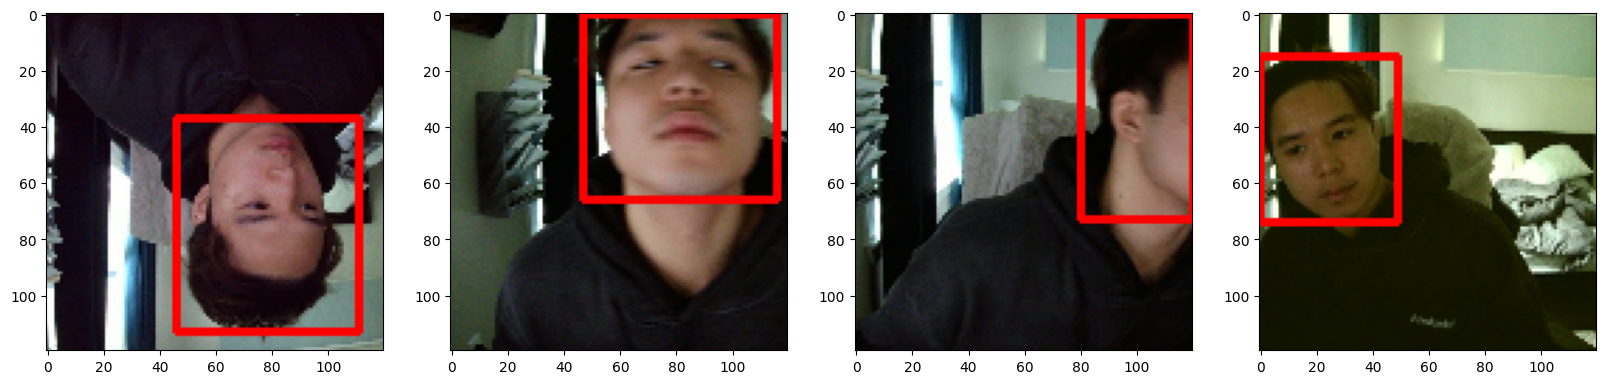

In [381]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    sample_image_cv2 = cv2.UMat(sample_image)
    print(sample_coords)
    
    cv2.rectangle(sample_image_cv2, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    #ax[idx].imshow(sample_image)
    ax[idx].imshow(cv2.UMat.get(sample_image_cv2))

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [382]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [383]:
vgg = VGG16(include_top=False)

In [384]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [385]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [386]:
facetracker = build_model()

In [387]:
facetracker.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_2        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_3        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_3[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           2,049 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 4)                 │           8,196 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [388]:
X, y = train.as_numpy_iterator().next()

In [389]:
X.shape

(8, 120, 120, 3)

In [390]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


In [391]:
classes, coords

(array([[0.5410248 ],
        [0.4110082 ],
        [0.39152876],
        [0.3950386 ],
        [0.45048246],
        [0.42261872],
        [0.37662262],
        [0.42275032]], dtype=float32),
 array([[0.40761158, 0.39892423, 0.61622846, 0.5251031 ],
        [0.44942307, 0.43400958, 0.5276536 , 0.50237453],
        [0.42628807, 0.3903669 , 0.5488687 , 0.5116389 ],
        [0.40992334, 0.44881997, 0.5304731 , 0.48974463],
        [0.4080912 , 0.48123717, 0.6250444 , 0.5418476 ],
        [0.45172632, 0.50259244, 0.5692835 , 0.5195066 ],
        [0.41637012, 0.425822  , 0.58584404, 0.5650999 ],
        [0.464305  , 0.43336228, 0.5798304 , 0.47982752]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [392]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [393]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [394]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [395]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [396]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8078573>

In [397]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.80499065>

In [398]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8078573>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [445]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            y0 = tf.reshape(y[0], [tf.shape(classes)[0], 1])
            #y1 = tf.reshape(y[0], [tf.shape(coords)[0], 1])
            
            batch_classloss = self.closs(y0, classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        y0 = tf.reshape(y[0], [tf.shape(classes)[0], 1])
        
        batch_classloss = self.closs(y0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [446]:
model = FaceTracker(facetracker)

In [447]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [448]:
logdir='logs'

In [449]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [450]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 419s 876ms/step - class_loss: 0.0967 - regress_loss: 0.1942 - total_loss: 0.2426 - val_class_loss: 0.0149 - val_regress_loss: 0.2339 - val_total_loss: 0.2413
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 412s 866ms/step - class_loss: 0.0521 - regress_loss: 0.1074 - total_loss: 0.1335 - val_class_loss: 0.9223 - val_regress_loss: 0.6767 - val_total_loss: 1.1378
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 412s 868ms/step - class_loss: 0.0453 - regress_loss: 0.0873 - total_loss: 0.1099 - val_class_loss: 1.2801 - val_regress_loss: 0.7853 - val_total_loss: 1.4254
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 408s 859ms/step - class_loss: 0.0340 - regress_loss: 0.0615 - total_loss: 0.0785 - val_class_loss: 1.9363 - val_regress_loss: 1.4768 - val_total_loss: 2.4449
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 408s 858ms/step - class_loss: 0.0285 - regress_loss: 0.0555 - total_loss: 0.0697 - val_class_loss: 0.1253 - val_regress_loss: 0.3374 - val_total_loss: 0.4001
Epoch 6/10

### 10.3 Plot Performance

In [451]:
hist.history

{'class_loss': [0.23437534272670746,
  0.0004885480157099664,
  0.000618023972492665,
  0.000749037426430732,
  0.0009876758558675647,
  0.327890008687973,
  0.036194805055856705,
  0.00013884984946344048,
  1.305775867876946e-06,
  4.259396519046277e-06],
 'regress_loss': [0.32980877161026,
  0.01617945358157158,
  0.02071923017501831,
  0.003669074736535549,
  0.008219046518206596,
  0.4739324152469635,
  0.04631417244672775,
  0.01296631433069706,
  0.009014351293444633,
  0.009929627180099487],
 'total_loss': [0.44699645042419434,
  0.016423728317022324,
  0.021028243005275726,
  0.0040435935370624065,
  0.008712884038686752,
  0.6378774046897888,
  0.06441157311201096,
  0.013035738840699196,
  0.009015004150569439,
  0.009931757114827633],
 'val_class_loss': [0.014863184653222561,
  0.922278642654419,
  1.2800822257995605,
  1.9363434314727783,
  0.12533099949359894,
  2.3376259803771973,
  1.5762033462524414,
  0.7700191736221313,
  0.17836502194404602,
  7.578009535791352e-05],

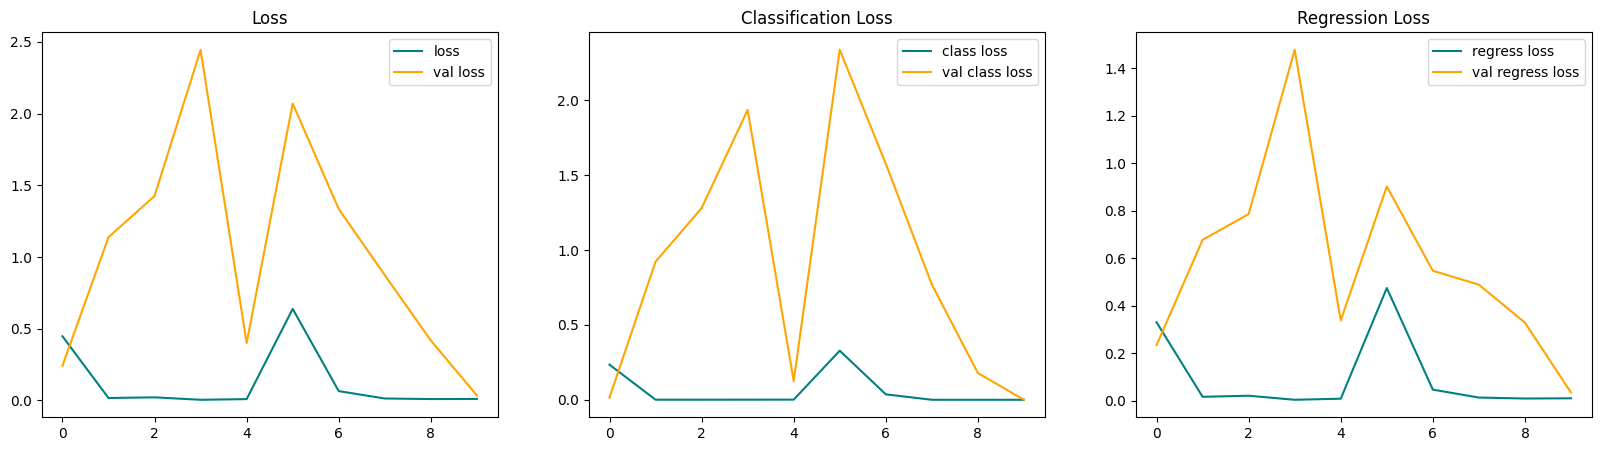

In [452]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [453]:
test_data = test.as_numpy_iterator()                                                                                                                                                                                                                                                                                                                                         

In [454]:
test_sample = test_data.next()

In [455]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


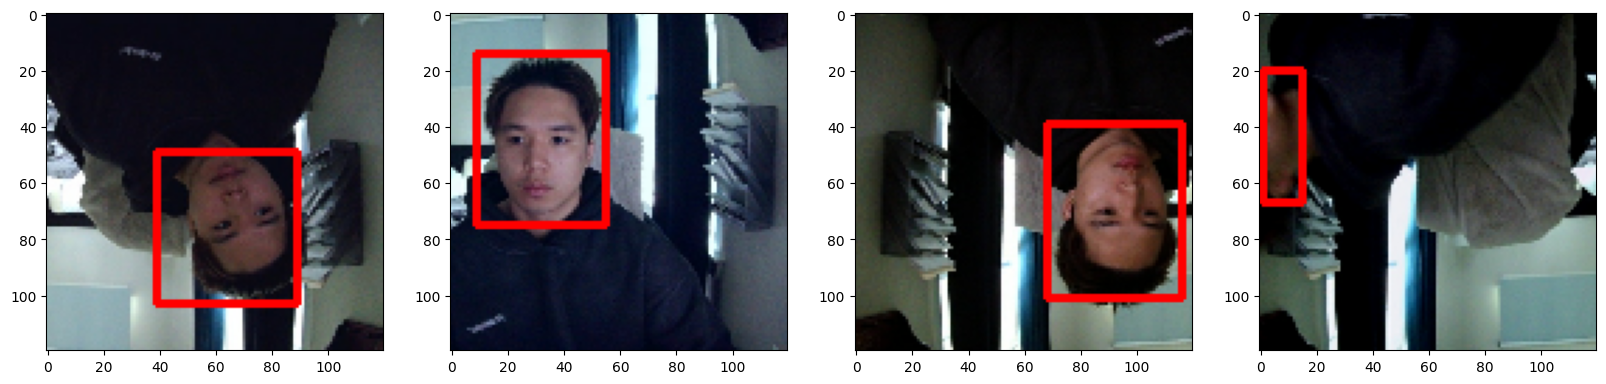

In [459]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image_cv2 = cv2.UMat(sample_image)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image_cv2, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    # ax[idx].imshow(sample_image)
    ax[idx].imshow(cv2.UMat.get(sample_image_cv2))

### 11.2 Save the Model

In [460]:
from tensorflow.keras.models import load_model

In [463]:
facetracker.save('facetracker.keras')

In [464]:
facetracker = load_model('facetracker.keras')

### 11.3 Real Time Detection

In [466]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━